# How to generate Toybrain dataset?

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
# standard python packages
import os, sys
from glob import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import matplotlib.image as mpimg
from sklearn import datasets, linear_model
import random
import math
import json

In [3]:
# import toybrains package
TOYBRAINS_DIR = os.path.abspath('../')
if TOYBRAINS_DIR not in sys.path:
    sys.path.append(TOYBRAINS_DIR)
from create_toybrains import ToyBrainsData
from utils.vizutils import *

The list of generative latent attributes of the images $L$ and their possible state can be printed with:

In [4]:
ToyBrainsData().show_all_states()


Image attributes (fixed):
Name                States                                                                      Weights
------------------  --------------------------------------------------------------------------  -------------------------------------------------
brain-vol_radminor  [20 21 22 23 24]                                                            [0. 0. 0. 0. 0.]
brain-vol_radmajor  [26 27 28 29 30]                                                            [0. 0. 0. 0. 0.]
brain_thick         [1 2 3 4]                                                                   [0. 0. 0. 0.]
brain-int_fill      [210 200 190 180 170]                                                       [0. 0. 0. 0. 0.]
brain-int_border    ['0-mediumslateblue' '1-slateblue' '2-darkslateblue' '3-darkblue']          [0. 0. 0. 0.]
vent_thick          [1 2 3 4]                                                                   [0. 0. 0. 0.]
shape-top_int       ['0-indianred' '1-salmon' '2-light

## (Step 1) Define the generative graph in a config file 
The config file is a python file with dictionaries and lists that [define the edges and nodes of the generative graph](../docs/formal_definition_and_proof.md#the-generative-graph-) $\mathcal{G}$. <br>
* The config file contains, <br>
     1. the list of covariates $C$ and the label $y$.
     2. the relationship between each covariate and the latent image generation attributes $L$.
* The config file must be stored in a dir `configs/`<br>

#### Writing the config file for the python class `ToyBrainsData()`: 
The config file is a `.py` file that contains 2 dictionaries:
    - A dict `COVARS` that defines all the 'influential' covariates. That is, it lists the names and their state of the variables from $C$ and $L$.
    - A dict `RULES_COV_TO_GEN` that defines the relationship between the label, the covariates, and the generative parameters, $y \mapsto L$, $c_k \mapsto L$, $c_k \mapsto y$.
    - Optionally, a list `CONS` that explicitly mentions which covariates among `COVARS` belong to $C_{enc}$.
    <br> (Test that all the config files meet the expectations by executing `ToyBrainsData(config).show_current_config()`)


* Example config file:

In [5]:
! head -30 configs/example_lbl1cov1.py

import numpy as np
import os, shutil 
from copy import copy, deepcopy
        
# Define all covariates (including labels)
COVARS = {'cov_site'   : dict(states=['siteA', 'siteB']),
          'lbl_lesion' : dict(states=['disease', 'ctrl'])}

# Rules about which covariate-state influences which generative variables
RULES_COV_TO_GEN = {
    ## (1) c --> X: `siteA -> brain intensity is higher` 
    'cov_site':{
        'siteA':{ 
            'brain-int_fill'    : {'amt': [0, 0.25, 0.25, 1.0, 1.75]}, 
            ## (2) c --> y: `siteA -> more likely to be lesion group` 
            'lbl_lesion'        : {'amt': [0.25, 1.25]}
        },
        'siteB':{
            'brain-int_fill'    : {'amt': [1.75, 1.0, 0.25, 0.25, 0.]},
            ## (2) c --> y: `siteB -> more likely to be control group` 
            'lbl_lesion'        : {'amt': [1.25, 0.25]}
        },
    },
    
    ## (3) X --> y: `lbl_lesion is True -> Volume of mid-right lesion is higher`
    'lbl_lesion':{
        'disease':{ 

### Load the config into the Toybrains class

In [6]:
toy = ToyBrainsData(config='configs.example_lbl1cov1.py', verbose=2)

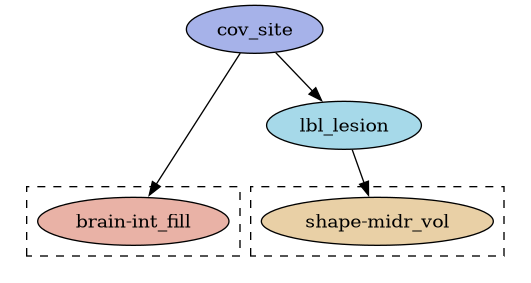

In [7]:
# show the causal graph (directed acyclic graph) of the toy data
from IPython.display import Image
Image(toy.draw_dag())

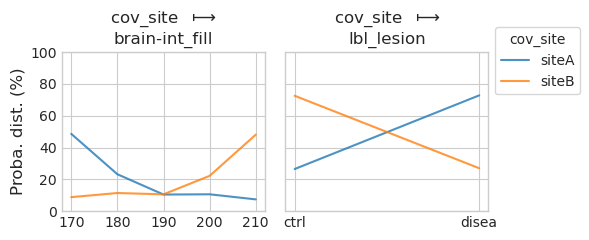

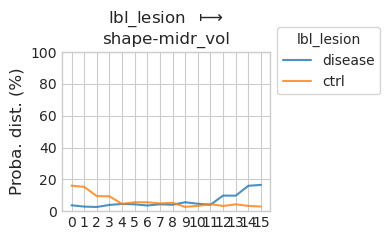

In [8]:
# show the probability distribution of the nodes configured
toy.show_current_config()

The nodes and edges of the causal graph can also be obtained as a list:

In [9]:
toy.CGM_nodes

['brain-int_fill', 'cov_site', 'lbl_lesion', 'shape-midr_vol']

In [10]:
toy.CGM_edges

[('cov_site', 'brain-int_fill'),
 ('cov_site', 'lbl_lesion'),
 ('lbl_lesion', 'shape-midr_vol')]

## (Step 2) Generate data table 
Sample the dataset and verify how the distributions will look. 
If some distribution isn't as expected then go back to step 1 and edit the config file accordingly.

In [11]:
df = toy.generate_dataset_table(n_samples=1000, outdir_suffix='lbl1cov1')

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:02<00:00, 342.40it/s]


* Visualize the dataframe dist.

In [12]:
df.head()

,cov_site,lbl_lesion,brain-int_border,brain-int_fill,brain-vol_radmajor,brain-vol_radminor,brain_thick,shape-botl_int,shape-botl_vol,shape-botr_int,...,probas_shape-botr_int,probas_shape-botr_vol,probas_shape-midl_int,probas_shape-midl_vol,probas_shape-midr_int,probas_shape-midr_vol,probas_shape-top_int,probas_shape-top_vol,probas_vent_thick,brain-vol
subjectID,,,,,,,,,,,,,,,,,,,,,
00000,siteA,ctrl,0-mediumslateblue,170,27,23,1,0-indianred,12,3-palegoldenrod,...,"[0.17, 0.17, 0.17, 0.17, 0.17, 0.17]","[0.06, 0.06, 0.06, 0.06, 0.06, 0.06, 0.06, 0.0...","[0.17, 0.17, 0.17, 0.17, 0.17, 0.17]","[0.06, 0.06, 0.06, 0.06, 0.06, 0.06, 0.06, 0.0...","[0.17, 0.17, 0.17, 0.17, 0.17, 0.17]","[0.16, 0.16, 0.1, 0.1, 0.05, 0.05, 0.05, 0.05,...","[0.17, 0.17, 0.17, 0.17, 0.17, 0.17]","[0.06, 0.06, 0.06, 0.06, 0.06, 0.06, 0.06, 0.0...","[0.25, 0.25, 0.25, 0.25]",1950.929038
00001,siteB,disease,1-slateblue,180,28,22,2,1-salmon,9,3-palegoldenrod,...,"[0.17, 0.17, 0.17, 0.17, 0.17, 0.17]","[0.06, 0.06, 0.06, 0.06, 0.06, 0.06, 0.06, 0.0...","[0.17, 0.17, 0.17, 0.17, 0.17, 0.17]","[0.06, 0.06, 0.06, 0.06, 0.06, 0.06, 0.06, 0.0...","[0.17, 0.17, 0.17, 0.17, 0.17, 0.17]","[0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.0...","[0.17, 0.17, 0.17, 0.17, 0.17, 0.17]","[0.06, 0.06, 0.06, 0.06, 0.06, 0.06, 0.06, 0.0...","[0.25, 0.25, 0.25, 0.25]",1935.221075
00002,siteB,disease,3-darkblue,180,30,21,4,1-salmon,1,0-indianred,...,"[0.17, 0.17, 0.17, 0.17, 0.17, 0.17]","[0.06, 0.06, 0.06, 0.06, 0.06, 0.06, 0.06, 0.0...","[0.17, 0.17, 0.17, 0.17, 0.17, 0.17]","[0.06, 0.06, 0.06, 0.06, 0.06, 0.06, 0.06, 0.0...","[0.17, 0.17, 0.17, 0.17, 0.17, 0.17]","[0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.0...","[0.17, 0.17, 0.17, 0.17, 0.17, 0.17]","[0.06, 0.06, 0.06, 0.06, 0.06, 0.06, 0.06, 0.0...","[0.25, 0.25, 0.25, 0.25]",1979.203372
00003,siteB,disease,3-darkblue,200,26,24,1,4-lightgreen,11,1-salmon,...,"[0.17, 0.17, 0.17, 0.17, 0.17, 0.17]","[0.06, 0.06, 0.06, 0.06, 0.06, 0.06, 0.06, 0.0...","[0.17, 0.17, 0.17, 0.17, 0.17, 0.17]","[0.06, 0.06, 0.06, 0.06, 0.06, 0.06, 0.06, 0.0...","[0.17, 0.17, 0.17, 0.17, 0.17, 0.17]","[0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.0...","[0.17, 0.17, 0.17, 0.17, 0.17, 0.17]","[0.06, 0.06, 0.06, 0.06, 0.06, 0.06, 0.06, 0.0...","[0.25, 0.25, 0.25, 0.25]",1960.353816
00004,siteB,ctrl,2-darkslateblue,210,26,22,3,0-indianred,3,3-palegoldenrod,...,"[0.17, 0.17, 0.17, 0.17, 0.17, 0.17]","[0.06, 0.06, 0.06, 0.06, 0.06, 0.06, 0.06, 0.0...","[0.17, 0.17, 0.17, 0.17, 0.17, 0.17]","[0.06, 0.06, 0.06, 0.06, 0.06, 0.06, 0.06, 0.0...","[0.17, 0.17, 0.17, 0.17, 0.17, 0.17]","[0.16, 0.16, 0.1, 0.1, 0.05, 0.05, 0.05, 0.05,...","[0.17, 0.17, 0.17, 0.17, 0.17, 0.17]","[0.06, 0.06, 0.06, 0.06, 0.06, 0.06, 0.06, 0.0...","[0.25, 0.25, 0.25, 0.25]",1796.990998


#### (a) Viz image attributes vs covariates dist.

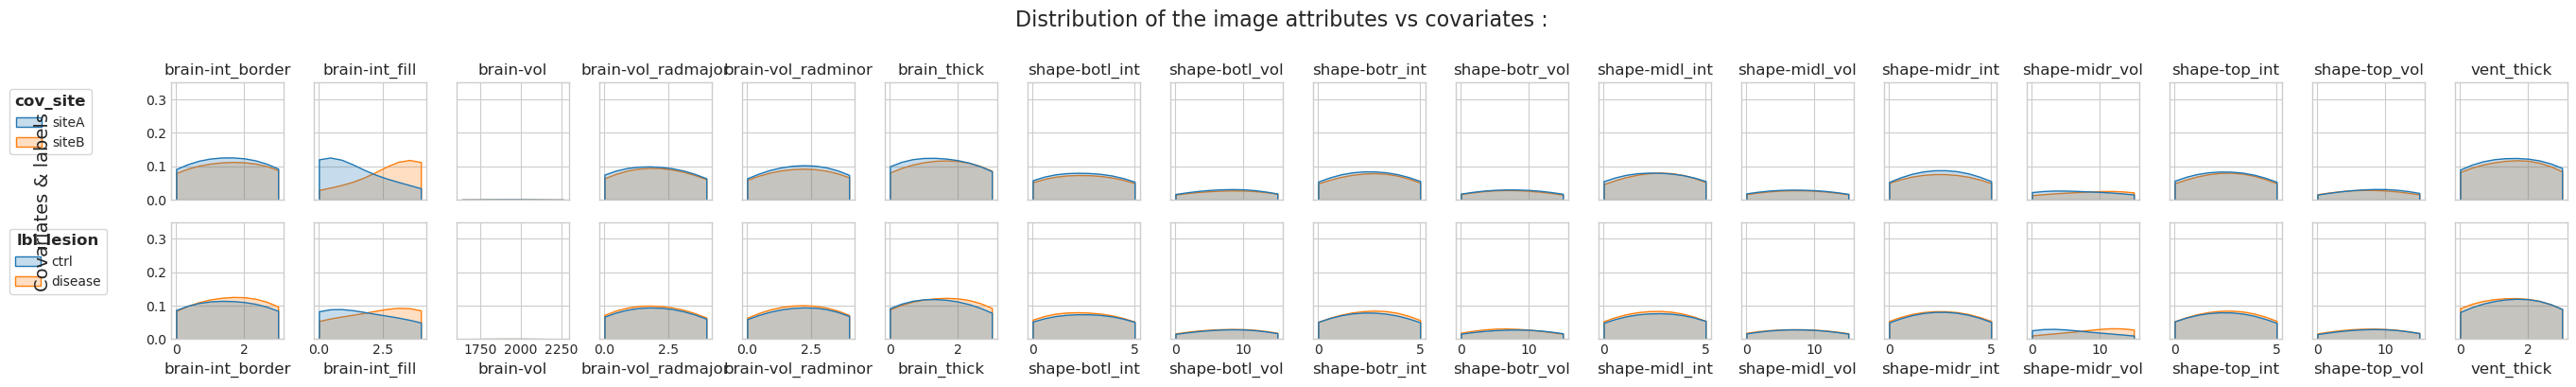

In [13]:
cov_cols = [c for c in df.filter(regex='^(cov_|lbl_)').columns if not c.startswith('probas_')]
attr_cols = [c for c in df.filter(regex='^(?!(cov_|lbl_)).+').columns if not c.startswith('probas_')]
plot_col_dists(df, 
               attr_cols=attr_cols, 
               cov_cols=cov_cols, 
               title="Distribution of the image attributes vs covariates :")
plt.show()

#### (b) Viz dist. of all variables in the dataset

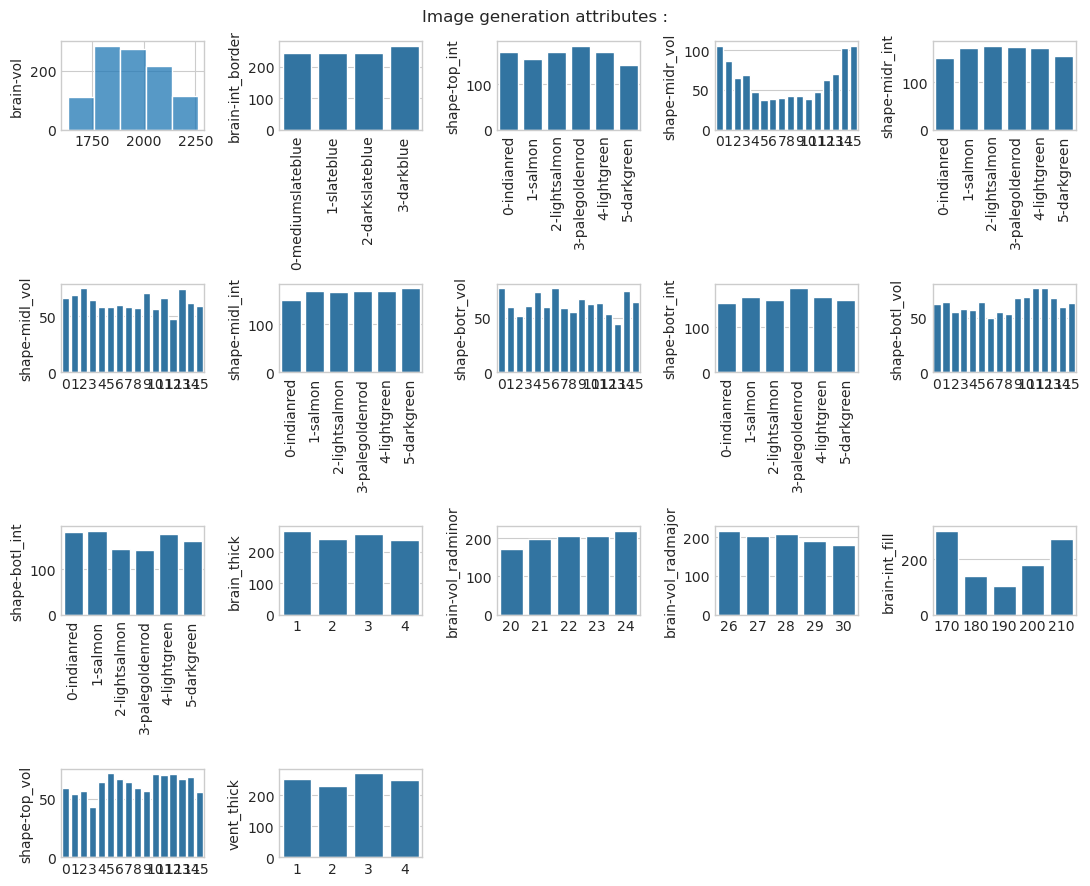

In [14]:
# get all column names starting with 'gen_'
plot_col_counts(df[attr_cols], title="Image generation attributes :")
plt.show()

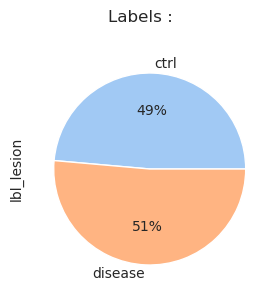

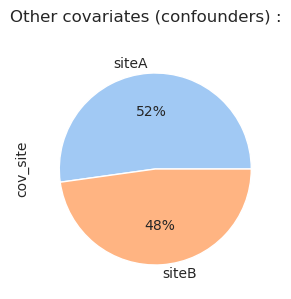

In [15]:
# get all column names starting with 'gen_'
plot_col_counts(df.filter(regex='^lbl'), title="Labels :")
plt.show()
# get all column names starting with 'gen_'
plot_col_counts(df.filter(regex='^cov_'), title="Other covariates (confounders) :")
plt.show()

## (Step 3) Estimate expected ML accuracies 

* You can estimate the maximum expected accuracy of the dataset by fitting a logistic regression model $f_v: L \Rightarrow v$
* This accuracy serves as the maximum expected accuracy that can be expected from a ML model trained on this dataset. This is because the ML models are trained on images that are a noisy rendition of the latents $X = g(L + \eta)$.
* Fit a logistic regression model to predict all the labels and covariate from image generative attributes: $f_v: L \Rightarrow v \;\;|\;\; \forall  v  \in \{y\} \cup \{C\}$ 
* The accuracy $A(\hat{v}, v)$, where $\hat{v}$ are the predictions of $f_v$, measures the univariate association $P(v | L)$ configured in the dataset.


In [16]:
df_results = toy.fit_contrib_estimators(
    input_feature_sets=["attr_all", 
                        "attr_subsets", "cov_subsets"],
    n_jobs=1, verbose=2)

--------------------------------------------------
[parallel jobs] Estimating baseline contrib scores on dataset: train
 ... running a total of 35 different settings of [input] x [output] x [CV]
Model           : LR({})
Input Features  :(name=attr_all, n=16) ['brain-vol_radminor', 'brain-vol_radmajor', 'brain_thick', '...', 'shape-botr_vol', 'shape-botl_int', 'shape-botl_vol']
Output label    : lbl_lesion
Confound control: baseline
Model           : LR({'penalty': 'l2', 'C': 1.0, 'solver': 'lbfgs'})
Input Features  :(name=attr_all, n=16) ['brain-vol_radminor', 'brain-vol_radmajor', 'brain_thick', '...', 'shape-botr_vol', 'shape-botl_int', 'shape-botl_vol']
Output label    : lbl_lesion
Confound control: baseline
Model           : LR({'penalty': 'l2', 'C': 1.0, 'solver': 'lbfgs'})
Input Features  :(name=attr_all, n=16) ['brain-vol_radminor', 'brain-vol_radmajor', 'brain_thick', '...', 'shape-botr_vol', 'shape-botl_int', 'shape-botl_vol']
Output label    : lbl_lesion
Confound control: bas

We can also inspect the results: 

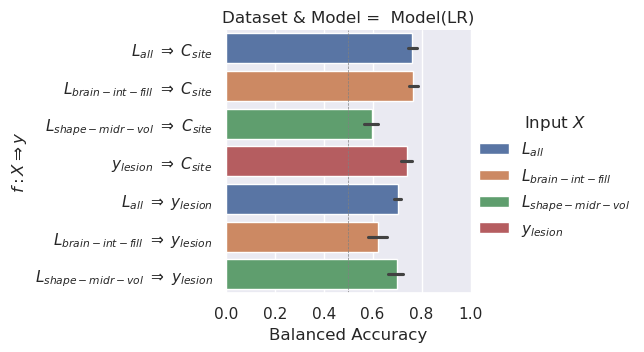

In [17]:
viz_contribs_univariate(df_results)
plt.show()

In [ ]:
show_contrib_table(df_results)

All scores are converted to percentages (%)


<span style="color:red">[TODO] Show how to generate OOD test datasets and use it to measure the effect sizes</span>

## (Step 4) Generate full dataset with images

In [19]:
toy.generate_dataset_images(n_jobs=10)

Generating n=1000 toybrain images


100%|██████████| 1000/1000 [00:37<00:00, 26.43it/s]


Visualize some of the generated images

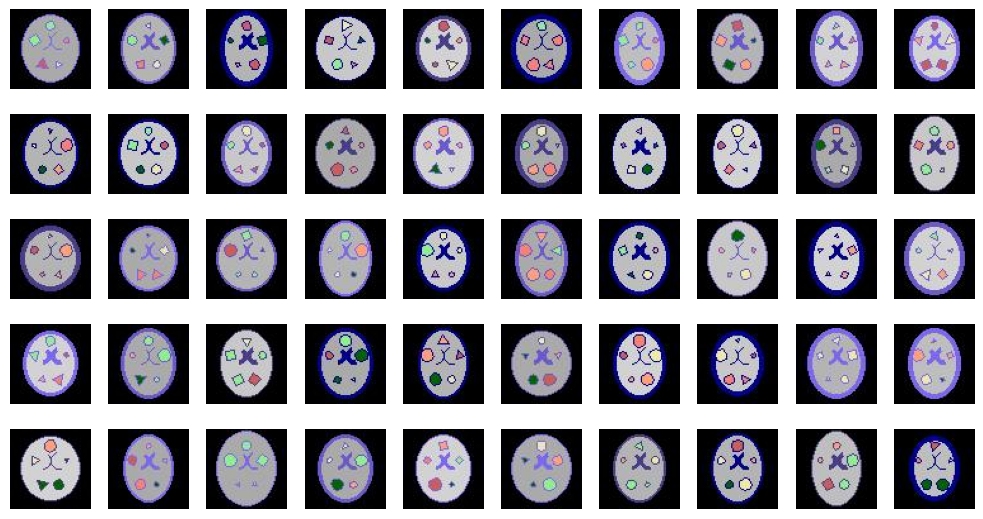

In [20]:
img_files = sorted(glob(f"{toy.DATASET_DIR}/images/*.jpg"))
show_images(img_files=img_files, n_rows=5)

### Step 2 & 4 can be done in one step
with 
```python 
toy.generate_dataset(n_samples=1000)
```
that internally calls
```python 
toy.generate_dataset_table(n_samples=1000)
toy.generate_dataset_images()
```

## Alternatively, toybrains dataset can be generated from the commandline

In [21]:
# generating 100 samples with debug switch turned on
! python3 ../create_toybrains.py -c configs.example_lbl1cov1 -n 100 -v 2 

100%|████████████████████████████████████████| 100/100 [00:00<00:00, 293.78it/s]
Generating n=100 toybrain images
100%|█████████████████████████████████████████| 100/100 [00:08<00:00, 12.47it/s]


## Let's generate a dataset with a more complex config

* This configuration has 5 labels and 3 covariates:

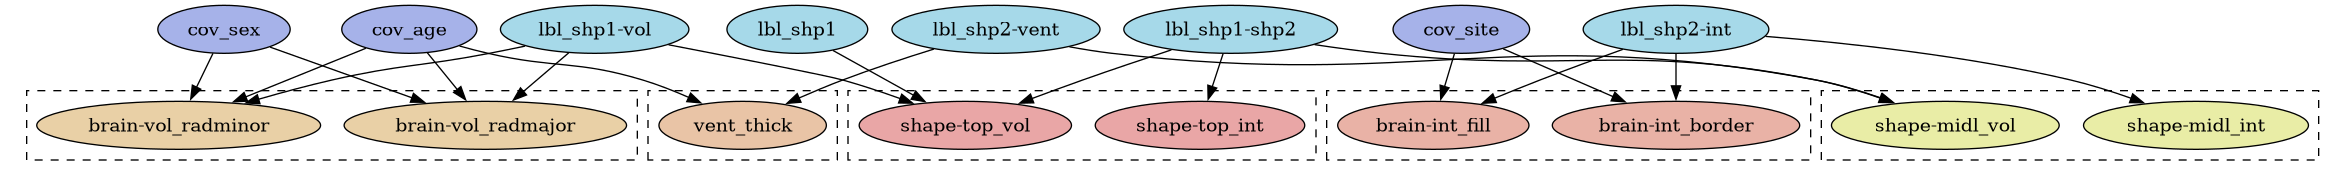

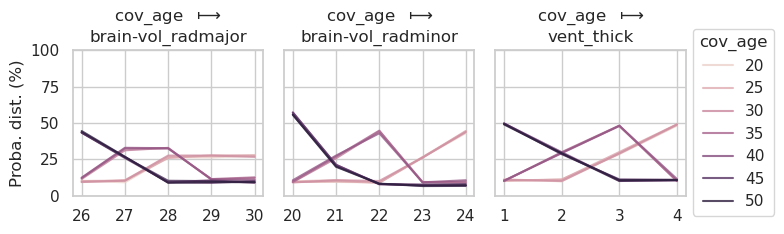

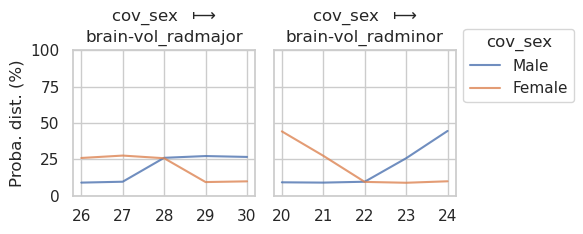

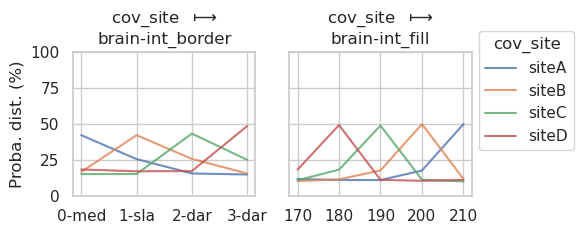

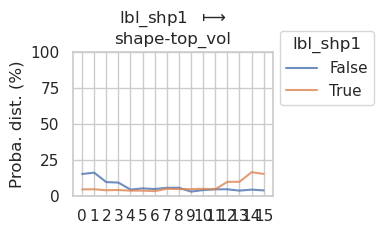

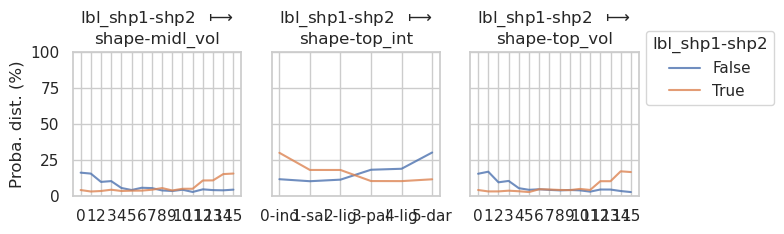

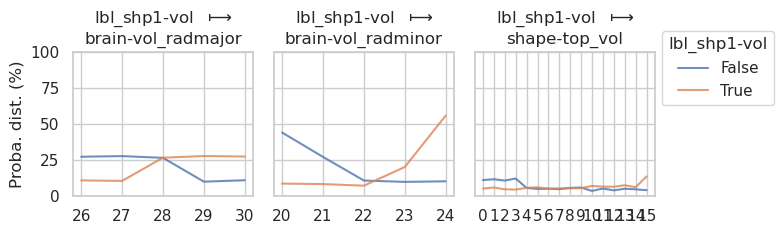

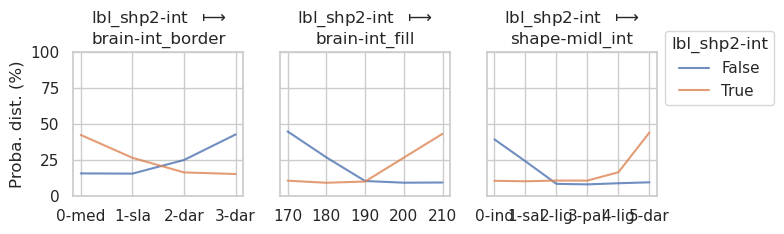

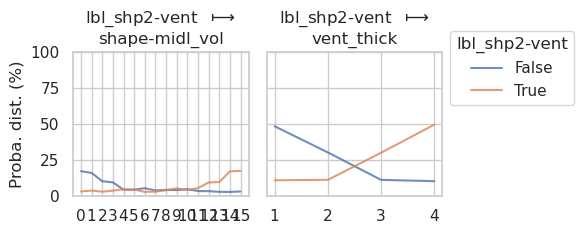

In [22]:
# add a tweaking config "lbl5cov3_tweak2.py" that will make the probability distributions 
# extremely distinct for all covariates AND it also creates a link between cov_site and shape-midl_int
toy2 = ToyBrainsData(config='configs.example_lbl5cov3')
display(Image(toy2.draw_dag()))
toy2.show_current_config()

In [23]:
df2 = toy2.generate_dataset_table(n_samples=1000, outdir_suffix='lbl5cov3')

100%|██████████| 1000/1000 [00:04<00:00, 240.73it/s]


In [24]:
df_results2 = toy2.fit_contrib_estimators(input_feature_sets=["attr_all", 
                                                            "attr_subsets", "cov_subsets"], 
                                                            # n_jobs=1, verbose=2
                                                            )

/ritter/roshan/installation/miniforge3/envs/toy/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.776e+04, tolerance: 6.412e+00 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/ritter/roshan/installation/miniforge3/envs/toy/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.730e+04, tolerance: 6.378e+00 Linear regression models with null weight for the l1 regularization term are more effi

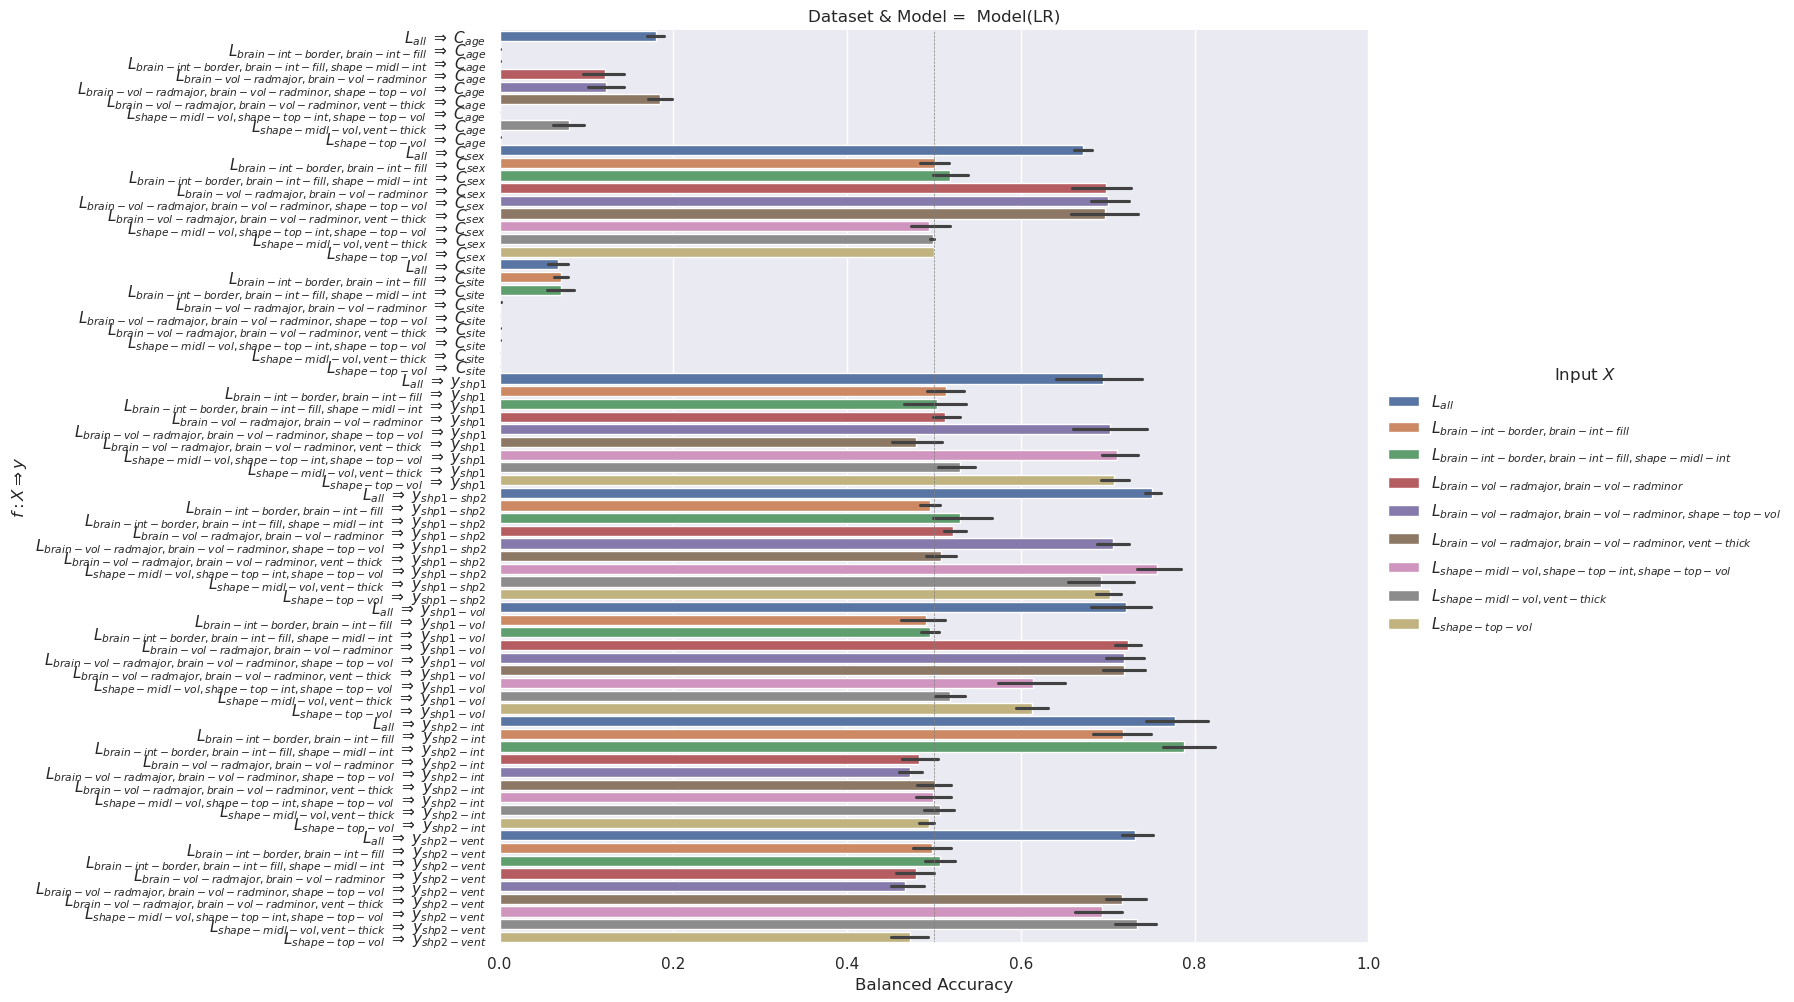

In [25]:
# visualize the results side by side 
viz_contribs_univariate(df_results2)
plt.show()